# Post-processing for OPF test cases

In this notebook, we will show how to post-process the results of the OPF test cases. The results are stored in the `results` folder. The model runs are in 2018. 

Includes the following scenarios:

1. Base case without renewable generation, stored in `results/wo_renew`.

2. Cases with renewable generation, stored in `results/w_renew`.


## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle

plt.rcParams["font.family"] = "Times New Roman"


In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

solar_data_dir = os.path.join(data_dir, 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

Grid data directory: /home/by276/models/NYgrid-python/data/grid
Figure directory: /home/by276/models/NYgrid-python/figures
Results directory: /home/by276/models/NYgrid-python/results
Solar data directory: /home/by276/models/NYgrid-python/data/solar
Onshore wind data directory: /home/by276/models/NYgrid-python/data/onshore_wind
Offshore wind data directory: /home/by276/models/NYgrid-python/data/offshore_wind


## Read grid data

In [7]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2018, 1, 5, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

In [8]:
# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'

# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'


## Read OPF results

In [12]:
thermal_pg_wo_renew_list = list()
thermal_pg_w_renew_list = list()
model_wo_renew_list = list()
model_w_renew_list = list()
results_wo_renew_list = list()
results_w_renew_list = list()

# Loop through all days
for d in range(len(timestamp_list)-1):
    # Set up timestamps
    start_datetime = timestamp_list[d]
    end_datetime = start_datetime + timedelta(hours=23)

    # Read thermal generation without renewable energy
    filename = f'thermal_wo_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.csv'
    thermal_pg_wo_renew = pd.read_csv(os.path.join(results_dir, 'wo_renew', filename),
                                      parse_dates=['TimeStamp'], index_col='TimeStamp')
    thermal_pg_wo_renew_list.append(thermal_pg_wo_renew)

    # Read pickle file
    filename = f'nygrid_sim_wo_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.pkl'
    with open(os.path.join(results_dir, 'wo_renew', filename), 'rb') as f:
        [nygrid_sim, model_multi_opf, results] = pickle.load(f)
    model_wo_renew_list.append(model_multi_opf)
    results_wo_renew_list.append(results)
    
    # Read thermal generation with renewable energy
    filename = f'thermal_w_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.csv'
    thermal_pg_w_renew = pd.read_csv(os.path.join(results_dir, 'w_renew', filename),
                                    parse_dates=['TimeStamp'], index_col='TimeStamp')
    thermal_pg_w_renew_list.append(thermal_pg_w_renew)

    # Read pickle file
    filename = f'nygrid_sim_w_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.pkl'
    with open(os.path.join(results_dir, 'w_renew', filename), 'rb') as f:
        [nygrid_sim, model_multi_opf, results] = pickle.load(f)
    model_w_renew_list.append(model_multi_opf)
    results_w_renew_list.append(results)

    print(f'Finished reading file for {start_datetime}')

# Concatenate thermal generation profiles
# thermal_pg_wo_renew = pd.concat(thermal_pg_wo_renew_list)
# thermal_pg_w_renew = pd.concat(thermal_pg_w_renew_list)

Finished reading file for 2018-01-01 00:00:00
Finished reading file for 2018-01-02 00:00:00
Finished reading file for 2018-01-03 00:00:00
Finished reading file for 2018-01-04 00:00:00


In [19]:
test = results_w_renew_list[0]['PG'] - results_wo_renew_list[0]['PG']
test.sum().sum()

0.0

In [14]:
results_wo_renew_list[0]['PG']

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
2018-01-01 00:00:00,0.0,0.0,0.0,66.0,0.1,11.1,20.0,349.0,539.0,153.0,...,0.000000,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 01:00:00,0.0,0.0,0.0,66.0,0.1,11.1,20.0,349.0,539.0,153.0,...,0.000000,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 02:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,153.0,...,0.000000,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 03:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,153.0,...,102.152196,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 04:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,153.0,...,0.000000,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 05:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.0,539.0,153.0,...,103.225428,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 06:00:00,0.0,0.0,0.0,66.0,0.1,11.1,20.0,349.0,539.0,153.0,...,1.205304,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 07:00:00,0.0,0.0,0.0,66.0,0.1,11.1,20.0,349.0,539.0,153.0,...,0.000000,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 08:00:00,0.0,0.0,0.0,66.0,0.1,11.1,20.0,349.0,539.0,153.0,...,0.000000,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0
2018-01-01 09:00:00,0.0,0.0,0.0,66.0,0.1,11.1,20.0,349.0,539.0,153.0,...,108.426686,-1100.0,530.0,660.0,660.0,660.0,-530.0,-660.0,-660.0,-660.0


In [49]:
thermal_pg_wo_renew

,59 St. GT 1,74 St. GT 1,74 St. GT 2,Allegany,Allied Frozen Storage,Arthur Kill Cogen,Arthur Kill GT 1,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,...,St. Elizabeth Medical Center,Sterling,Stony Brook (BTM:NG),Syracuse,Vernon Blvd 2,Vernon Blvd 3,Wading River 1,Wading River 2,Wading River 3,West Babylon 4
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31 00:00:00,0.0,0.0,0.0,11.0,1.492140e-11,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,61.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 01:00:00,0.0,0.0,0.0,11.0,-8.526513e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,20.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 02:00:00,0.0,0.0,0.0,11.0,2.927436e-10,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,14.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 03:00:00,0.0,0.0,0.0,11.0,-4.973799e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,14.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 04:00:00,0.0,0.0,0.0,11.0,-3.552714e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,14.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 05:00:00,0.0,0.0,0.0,11.0,7.105427e-13,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,55.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 06:00:00,0.0,0.0,0.0,11.0,-8.526513e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,96.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 07:00:00,0.0,0.0,0.0,11.0,-1.207923e-11,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 08:00:00,0.0,0.0,0.0,11.0,1.421085e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0


In [50]:
thermal_pg_w_renew

,59 St. GT 1,74 St. GT 1,74 St. GT 2,Allegany,Allied Frozen Storage,Arthur Kill Cogen,Arthur Kill GT 1,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,...,St. Elizabeth Medical Center,Sterling,Stony Brook (BTM:NG),Syracuse,Vernon Blvd 2,Vernon Blvd 3,Wading River 1,Wading River 2,Wading River 3,West Babylon 4
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31 00:00:00,0.0,0.0,0.0,11.0,1.492140e-11,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,61.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 01:00:00,0.0,0.0,0.0,11.0,-8.526513e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,20.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 02:00:00,0.0,0.0,0.0,11.0,2.927436e-10,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,14.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 03:00:00,0.0,0.0,0.0,11.0,-4.973799e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,14.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 04:00:00,0.0,0.0,0.0,11.0,-3.552714e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,14.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 05:00:00,0.0,0.0,0.0,11.0,7.105427e-13,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,55.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 06:00:00,0.0,0.0,0.0,11.0,-8.526513e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,96.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 07:00:00,0.0,0.0,0.0,11.0,-1.207923e-11,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-12-31 08:00:00,0.0,0.0,0.0,11.0,1.421085e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0


## Plotting

In [37]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


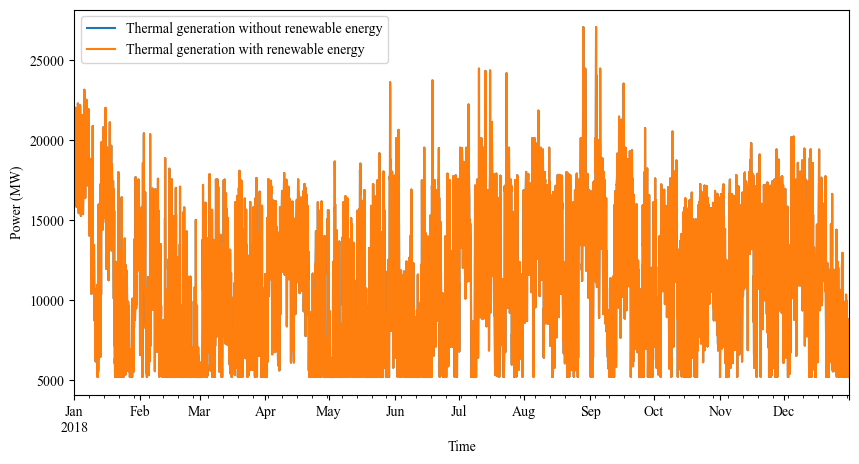

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
thermal_pg_wo_renew.sum(axis=1).plot(ax=ax, label='Thermal generation without renewable energy')
thermal_pg_w_renew.sum(axis=1).plot(ax=ax, label='Thermal generation with renewable energy')

ax.set_ylabel('Power (MW)')
ax.set_xlabel('Time')
ax.legend()
plt.show()  


In [46]:
start_datetime = datetime(2018, 1, 1, 0, 0, 0)
end_datetime = datetime(2018, 1, 3, 0, 0, 0)

NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object


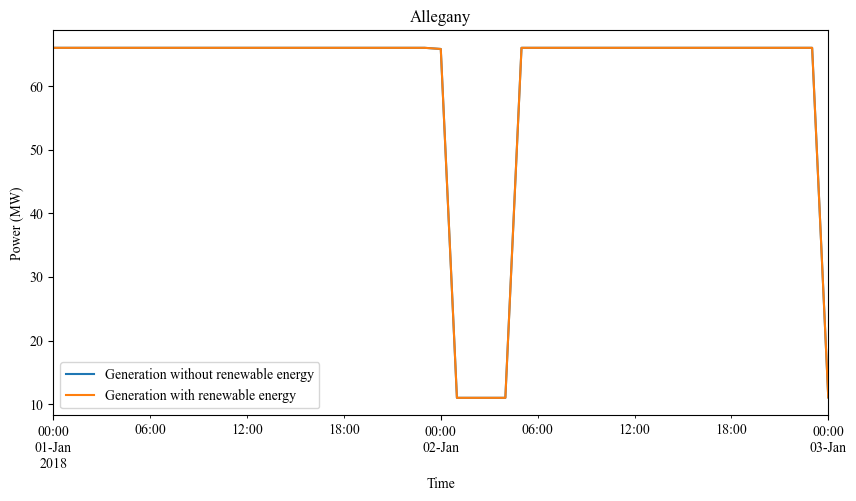

In [47]:
ii = 3

print(gen_info.iloc[ii, :])

fig, ax = plt.subplots(figsize=(10, 5))
thermal_pg_wo_renew.iloc[:, ii].plot(ax=ax, label='Generation without renewable energy')
thermal_pg_w_renew.iloc[:, ii].plot(ax=ax, label='Generation with renewable energy')

ax.set_xlim([start_datetime, end_datetime])

ax.set_ylabel('Power (MW)')
ax.set_xlabel('Time')
ax.set_title(gen_info.iloc[ii, :].NYISOName)
ax.legend()
plt.show()  

In [34]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


# Plots

# Total generation

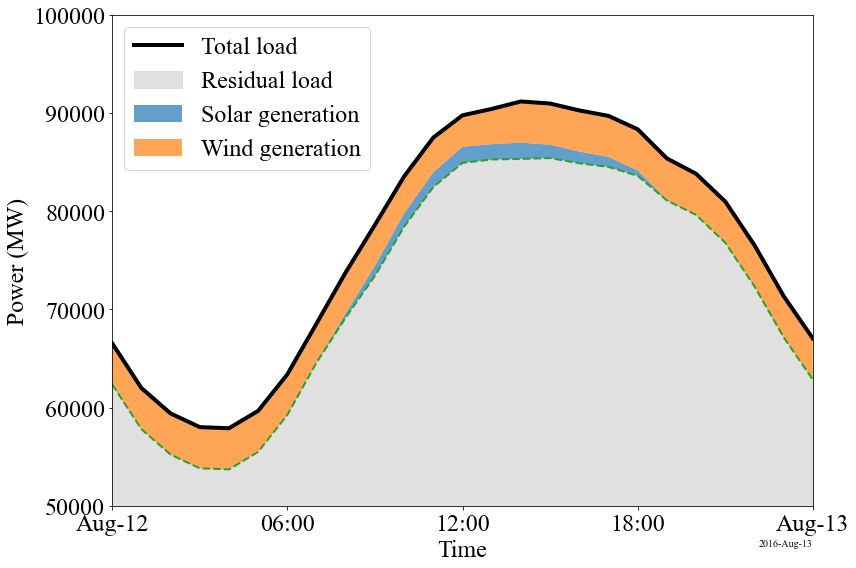

In [115]:
total_load = load.sum(axis=1)
total_load_new = load_new.sum(axis=1)
total_solar_gen = solar_gen[start_time: end_time].sum(axis=1)
total_wind_gen = wind_gen[start_time: end_time].sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(total_load.index, total_load, 
        color='black', linestyle='-', linewidth=4,
        label='Total load')
ax.plot(total_load_new.index, total_load_new,
        color='tab:green', linestyle='--', linewidth=2)

ax.fill_between(total_solar_gen.index, 0, total_load_new,
                alpha=0.7, color='lightgray',
                label='Residual load')

ax.fill_between(total_solar_gen.index, total_load_new, 
                total_load_new + total_solar_gen,
                alpha=0.7,
                label='Solar generation')
ax.fill_between(total_wind_gen.index, total_load_new + total_solar_gen, 
                total_load_new + total_solar_gen + total_wind_gen,
                alpha=0.7,
                label='Wind generation')

ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xlim(start_time, end_time)
ax.set_ylim(50000, 100000)
ax.set_xlabel('Time', fontsize=24)
ax.set_ylabel('Power (MW)', fontsize=24)
ax.tick_params(axis='both', labelsize=24)
ax.legend(fontsize=24)

fig_name = f'../figures/load_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.png'
fig.tight_layout()
fig.savefig(fig_name, dpi=300)
plt.show()

## Individual generators

In [112]:
def plot_gen(gen_name, thermal_pg, thermal_pg_new):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.plot(thermal_pg.index, thermal_pg[gen_name], linestyle='-',
            label='Base case')
    ax.plot(thermal_pg_new.index, thermal_pg_new[gen_name], linestyle='--',
            label='With renewable')

    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    ax.set_xlim(start_time, end_time)
    # ax.set_ylim(0, 70)

    ax.set_title(gen_name, fontsize=24)
    ax.set_xlabel('Time', fontsize=24)
    ax.set_ylabel('Generation (MW)', fontsize=24)
    ax.tick_params(axis='both', labelsize=24)
    ax.legend(fontsize=24)
    fig.tight_layout()

    return fig, ax

In [113]:
for gen_name in thermal_pg.columns:

    fig, ax = plot_gen(gen_name, thermal_pg, thermal_pg_new)
    
    fig_name = f'../figures/thermal_gen/{gen_name.replace("/", "")}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.png'
    fig.savefig(fig_name, dpi=300)
    plt.close()
    